/home/bongiwe/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


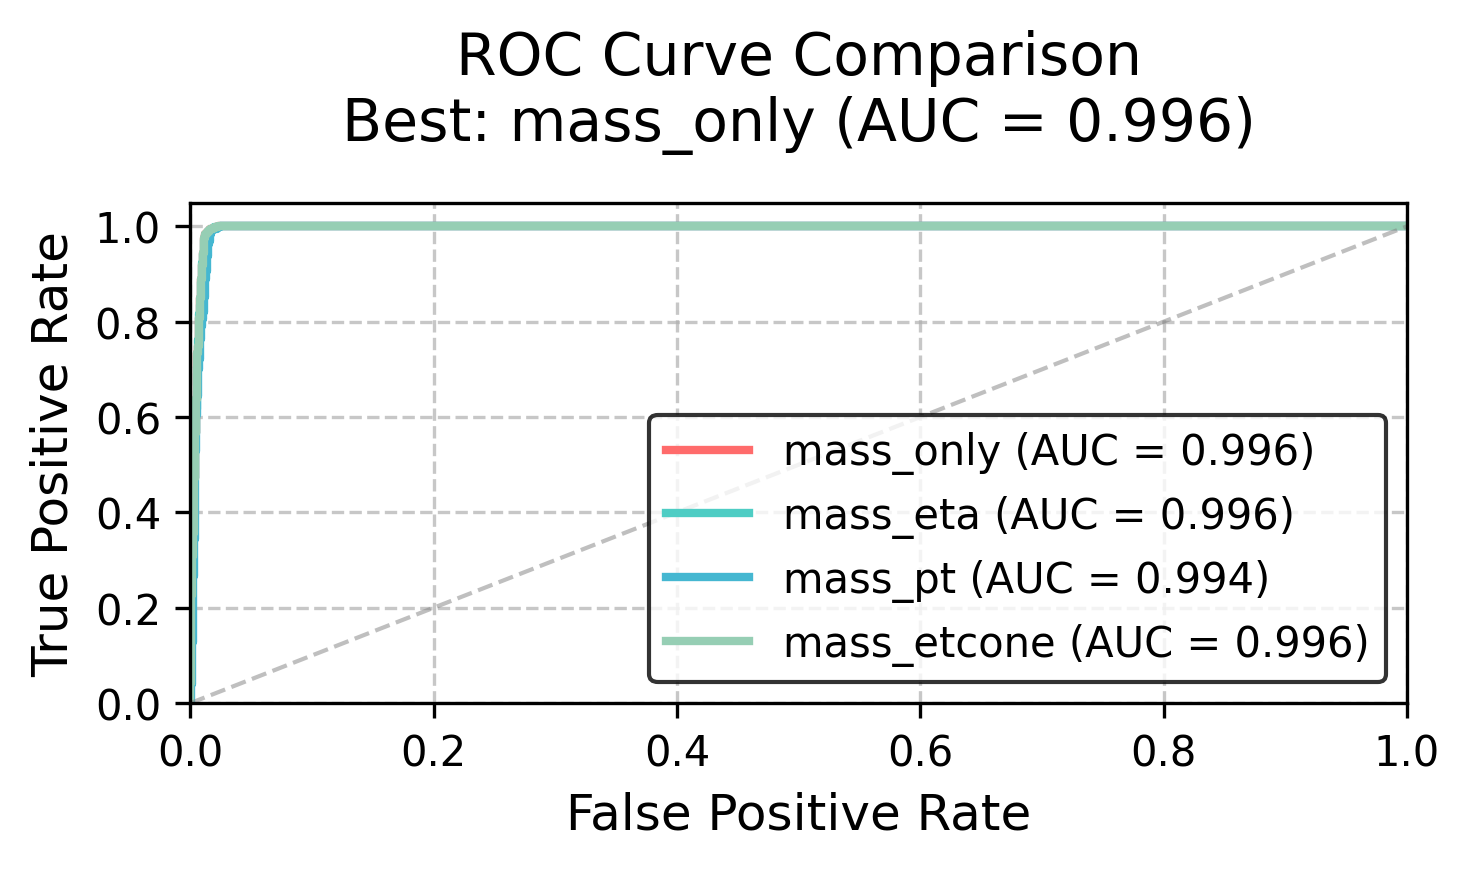

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

# ----------------------------
# Simulate signal data (centered around 125.88 GeV)
num_signal = int(np.round(503.7))
signal = pd.DataFrame({
    'myy': np.random.normal(125.88, 0.45, num_signal),
    'photon_pt': [list(np.random.uniform(30000, 40000, 2)) for _ in range(num_signal)],
    'photon_etcone20': [list(np.random.uniform(4000, 4000, 2)) for _ in range(num_signal)],
    'photon_eta': [list(np.random.uniform(1.45, 1.60, 2)) for _ in range(num_signal)],
    'label': 1
})

# Simulate background data
num_background = int(np.round(7031.6))
background = pd.DataFrame({
    'myy': np.random.normal(120.06, 66.83, num_background),
    'photon_pt': [list(np.random.uniform(20000, 60000, 2)) for _ in range(num_background)],
    'photon_etcone20': [list(np.random.uniform(4000, 4000, 2)) for _ in range(num_background)],
    'photon_eta': [list(np.random.uniform(1.45, 1.64, 2)) for _ in range(num_background)],
    'label': 0
})

# Combine data
data = pd.concat([signal, background], ignore_index=True)

# Data preprocessing: Remove outliers in myy
data = data[np.abs(data['myy'] - data['myy'].mean()) <= (3 * data['myy'].std())]

# ----------------------------
# Photon eta filter with error handling
def eta_filter(eta_list):
    try:
        eta0, eta1 = eta_list
        return (1.45 <= abs(eta0) <= 1.60) and (1.45 <= abs(eta1) <= 1.60)
    except (TypeError, IndexError):
        return False

data = data[data['photon_eta'].apply(eta_filter)]

# ----------------------------
# Signal mass
signal_mass = 125.88

# Optimized scoring functions with normalized outputs
scoring_functions = {
    'mass_only': lambda df: np.tanh(1 / (1 + abs(df['myy'] - signal_mass) / 0.45)),
    
    'mass_eta': lambda df: np.tanh(
        (1 / (1 + abs(df['myy'] - signal_mass) / 0.45)) *
        df['photon_eta'].apply(lambda x: np.mean(np.abs(np.array(x))))
    ),
    
    'mass_pt': lambda df: np.tanh(
        (1 / (1 + abs(df['myy'] - signal_mass) / 0.45)) *
        (df['photon_pt'].apply(lambda x: sum(x)) / 80000)
    ),
    
    'mass_etcone': lambda df: np.tanh(
        (1 / (1 + abs(df['myy'] - signal_mass) / 0.45)) *
        (1 / (1 + df['photon_etcone20'].apply(lambda x: sum(x)) / 8000))
    )
}

# ----------------------------
# Plot all ROC curves
plt.figure(figsize=(5, 3), dpi=300)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
best_auc = 0
best_model = ''

for (name, func), color in zip(scoring_functions.items(), colors):
    df = data.copy()
    df['score'] = func(df)
    
    # Ensure scores are valid
    df = df[np.isfinite(df['score'])]
    
    fpr, tpr, _ = roc_curve(df['label'], df['score'])
    roc_auc = auc(fpr, tpr)

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = name

    plt.plot(fpr, tpr, lw=2, color=color, label=f'{name} (AUC = {roc_auc:.3f})')

# ----------------------------
# Enhanced plot styling
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve Comparison\nBest: {best_model} (AUC = {best_auc:.3f})', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save with higher quality
plt.savefig("higgs_roc_curve_comparison.png", dpi=300, bbox_inches='tight')